<a href="https://colab.research.google.com/github/anosharahim/capstone/blob/master/emotion_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


# Import Packages and Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
## for preprocessing
import pandas as pd
import os
import numpy as np
import random 

## For plotting
import seaborn as sns
import imageio
import matplotlib.pyplot as plt
import plotly.io as plt_io
import plotly.graph_objects as go
from IPython.display import Image
%matplotlib inline


## For machine learning
import tensorflow as tf
import tensorflow.keras as K
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler


# Load and Preprocess Image Data

In [ ]:
#get file paths for training and test images
train_path = '/content/drive/MyDrive/Capstone/FER2013/train/'
test_path = '/content/drive/MyDrive/Capstone/FER2013/test/'

#initialize lists to save data
train_data = []
train_label = []
test_data = []
test_label = []

#y label encoding in a dictionary
emotion_dictionary = {'angry':0, 'disgusted':1, 'fearful':2, 'happy':3, 'neutral':4, 'sad':5, 'surprised':6}

def unison_shuffled_copies(a, b):
    '''Shuffles two arrays in sync using permutations.'''
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

def get_image_arrays(folder_path, label_dict):
  '''Converts png images into numpy arrays with their labels and stores them in a shuffled array.

  Input:
  folder_path - Path to folder where images for each emotion are stored in a different folder
  label_dict - Dictionary of labels and their encodings   

  Output:
  data -  Array of image arrays
  label - Array of image labels 
  '''

  data = []
  label = []

  for category in os.listdir(folder_path): 
    category_name = label_dict[category]
    category_path = folder_path + category + '/'
    freq[category] = 0

    for image in os.listdir(category_path):
      image_file = category_path + image 
      image_array = imageio.imread(image_file) #get image array from file 
      #image_array.resize((32, 32))
      image_array = np.array(image_array) #convert to numpy array 
      #add image array and it's label to respective folders 
      data.append(image_array)
      label.append(category_name)

  data = np.array(data)
  label = np.array(label)
  data, label = unison_shuffled_copies(data, label)
  return data, label

#get test and training data in numpy array format from png files
train_data, train_label = get_image_arrays(train_path, emotion_dictionary)
test_data, test_label = get_image_arrays(test_path, emotion_dictionary)

#save test and training set for future use 
np.savez('/content/drive/MyDrive/Capstone/datasets/train.npz',train_data, train_label)
np.savez('/content/drive/MyDrive/Capstone/datasets/test.npz',test_data, test_label)


In [ ]:
#load data from gdrive
train_npz = np.load("/content/drive/MyDrive/Capstone/datasets/train.npz")
test_npz = np.load("/content/drive/MyDrive/Capstone/datasets/test.npz")

x_train = train_npz["arr_0"]
y_train = train_npz["arr_1"]
x_test = test_npz["arr_0"]
y_test = test_npz["arr_1"]

#check sizes
print('Train Size: ', x_train.shape, y_train.shape)
print('Test Size: ',x_test.shape, y_test.shape)

Train Size:  (28709, 48, 48) (28709,)
Test Size:  (7178, 48, 48) (7178,)


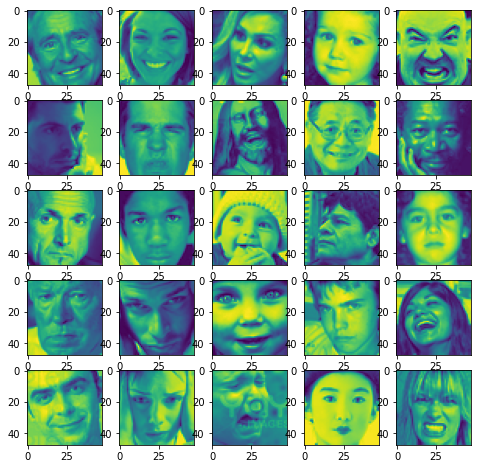

In [ ]:
#visualize random samples
fig, axes = plt.subplots(5,5, figsize=(8,8))
for i,ax in enumerate(axes.flat):
    ax.imshow(x_train[random.randint(0,len(x_train))])

Text(0.5, 1.0, 'Emotion Class Distribution in Training Data')

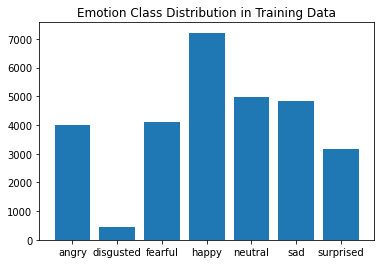

In [ ]:
### CLASS IMBALANCE 

#visualize class distribution
emotion_dictionary = {'angry':0, 'disgusted':1, 'fearful':2, 'happy':3, 'neutral':4, 'sad':5, 'surprised':6}
values, counts = np.unique(y_train, return_counts=True)

class_dist = {} #true class distribution
for i in range(len(values)):
  class_dist[i] = counts[i]

plt.bar(emotion_dictionary.keys(),class_dist.values())
plt.title("Emotion Class Distribution in Training Data")

<BarContainer object of 7 artists>

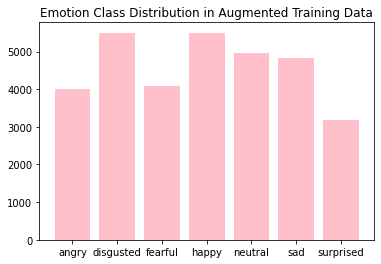

In [ ]:
#randomly undersample majority class 
class_undersample =  {0: 3995, 1: 436, 2: 4097, 3: 5500, 4: 4965, 5: 4830, 6: 3171}
x_train_reshape = x_train.reshape(len(x_train),48*48)
undersample = RandomUnderSampler(sampling_strategy=class_undersample)
x_train_under, y_train_under = undersample.fit_resample(x_train_reshape,y_train)

#oversample minority class  using k-nearest data augmentation
class_oversample =  {0: 3995, 1: 3500, 2: 4097, 3: 5500, 4: 4965, 5: 4830, 6: 3171}
sm = SMOTE(sampling_strategy='minority', random_state=42)
x_train, y_train = sm.fit_resample(x_train_under,y_train_under)

#visualize resampled class distribution 
values, counts_ = np.unique(y_train, return_counts=True)
plt.title("Emotion Class Distribution in Augmented Training Data")
plt.bar(emotion_dictionary.keys(),counts_, color = 'pink')

In [ ]:
#add 2 more channels to grayscale image to imitate rgb
x_train = np.repeat(x_train[..., np.newaxis], 3, -1)
x_test = np.repeat(x_test[..., np.newaxis], 3, -1)

#split test set into validation and test set 
x_val, x_test, y_val ,y_test = train_test_split(x_test,y_test, test_size=0.3)

#resize to make sure input is the correct shape
x_train = np.resize(x_train, (len(x_train), 48,48,3))
x_val = np.resize(x_val, (len(x_val), 48,48,3))
x_test = np.resize(x_test, (len(x_test), 48,48,3))

print('Train -- ', x_train.shape, y_train.shape)
print('Val -- ', x_val.shape, y_val.shape)
print('Test -- ', x_test.shape, y_test.shape)


Train --  (32058, 48, 48, 3) (32058,)
Val --  (5024, 48, 48, 3) (5024,)
Test --  (2154, 48, 48, 3) (2154,)


# Load and Compile Pre-trained Model

## VGGFace // VGGFace2

In [ ]:
#Load Pretrained ResNet50 Model 
input_tensor = K.Input(shape=(48,48,3))
res50_model = K.applications.ResNet50(include_top=False, weights="imagenet",input_tensor=input_tensor)

#Freezing Layers 
n_freeze = 163
for layer in res50_model.layers[:n_freeze]:
  layer.trainable =False

#verify that the desired layers are frozen 
for i, layer in enumerate(res50_model.layers):
  if i == 10:
    print("...")
  if i < 10 or i > (n_freeze - 3):  
    print(i,layer.name,'-',layer.trainable)

94781440/94765736 [==============================] - 0s 0us/step
0 input_1 - False
1 conv1_pad - False
2 conv1_conv - False
3 conv1_bn - False
4 conv1_relu - False
5 pool1_pad - False
6 pool1_pool - False
7 conv2_block1_1_conv - False
8 conv2_block1_1_bn - False
9 conv2_block1_1_relu - False
...
161 conv5_block2_3_conv - False
162 conv5_block2_3_bn - False
163 conv5_block2_add - True
164 conv5_block2_out - True
165 conv5_block3_1_conv - True
166 conv5_block3_1_bn - True
167 conv5_block3_1_relu - True
168 conv5_block3_2_conv - True
169 conv5_block3_2_bn - True
170 conv5_block3_2_relu - True
171 conv5_block3_3_conv - True
172 conv5_block3_3_bn - True
173 conv5_block3_add - True
174 conv5_block3_out - True


In [ ]:
## Build the model
model=K.models.Sequential()
model.add(res50_model) #pre-trained model with frozen layers 
# stacking more layers 
model.add(K.layers.Dropout(0.5))
model.add(K.layers.Flatten())
model.add(K.layers.BatchNormalization())
model.add(K.layers.Dense(32,kernel_initializer='he_uniform'))
model.add(K.layers.BatchNormalization())
model.add(K.layers.Activation('relu'))
model.add(K.layers.Dropout(0.5))
model.add(K.layers.Dense(32,kernel_initializer='he_uniform'))
model.add(K.layers.BatchNormalization())
model.add(K.layers.Activation('relu'))
model.add(K.layers.Dense(7,activation='softmax'))


## Compile Model 

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 dropout (Dropout)           (None, 2, 2, 2048)        0         
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 batch_normalization (BatchN  (None, 8192)             32768     
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 32)                262176    
                                                                 
 batch_normalization_1 (Batc  (None, 32)               128       
 hNormalization)                                        

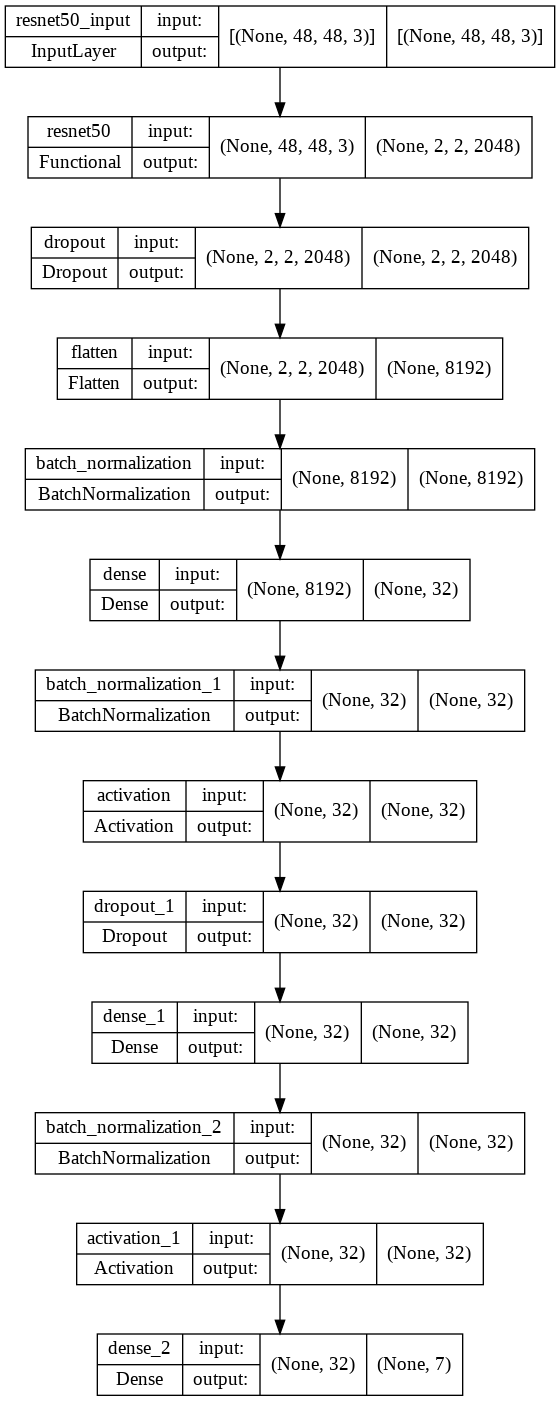

In [ ]:
plot_model(model, to_file='/content/drive/MyDrive/Capstone/datasetsmodel_plot.png', show_shapes=True, show_layer_names=True)

In [12]:
#compile model
model.compile(optimizer='Adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])

#create path to checkpoint to save model weights
ckpt_path = os.path.join('/content/drive/MyDrive/Capstone/datasets', 'ckpt') 

#reduce learning rate when performance doesn't increase for 5 epochs
lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 2,verbose = 1,factor = 0.1, min_lr = 1e-10)
#stop early if performance doesn't increase substantially for 10 epochs
es = EarlyStopping(min_delta=.01, verbose=1, patience=10)

#create model checkpoint to save weights
check_point = K.callbacks.ModelCheckpoint(filepath=  ckpt_path,
                                              monitor="val_accuracy",
                                              mode="max",
                                              save_best_only=True,)

#Train the model using min--batch gradient descent
history = model.fit(x_train, y_train, batch_size=256, epochs=20, verbose=1,
                        validation_data=(x_val, y_val),
                        callbacks=[lrd, check_point, es])

model.save(ckpt_path)

Epoch 1/20
126/126 [==============================] - 681s 5s/step - loss: 1.6306 - accuracy: 0.3866 - val_loss: 1.7655 - val_accuracy: 0.3483 - lr: 0.0010
Epoch 2/20
126/126 [==============================] - 724s 6s/step - loss: 1.3678 - accuracy: 0.4834 - val_loss: 1.4940 - val_accuracy: 0.4375 - lr: 0.0010
Epoch 3/20
126/126 [==============================] - 727s 6s/step - loss: 1.2392 - accuracy: 0.5319 - val_loss: 1.4749 - val_accuracy: 0.4486 - lr: 0.0010
Epoch 4/20
126/126 [==============================] - 764s 6s/step - loss: 1.1414 - accuracy: 0.5746 - val_loss: 1.4281 - val_accuracy: 0.4707 - lr: 0.0010
Epoch 5/20
126/126 [==============================] - 771s 6s/step - loss: 1.0440 - accuracy: 0.6187 - val_loss: 1.4632 - val_accuracy: 0.4739 - lr: 0.0010
Epoch 6/20
126/126 [==============================] - 748s 6s/step - loss: 0.9497 - accuracy: 0.6551 - val_loss: 1.5816 - val_accuracy: 0.4331 - lr: 0.0010
Epoch 7/20
126/126 [==============================] - 771s 6s/st

In [14]:
history.history


{'accuracy': [0.3866429626941681,
  0.48340508341789246,
  0.531879723072052,
  0.5745835900306702,
  0.6186911463737488,
  0.655125081539154,
  0.6987335681915283,
  0.7408758997917175,
  0.7815833687782288],
 'loss': [1.6306264400482178,
  1.3677890300750732,
  1.2392046451568604,
  1.1413711309432983,
  1.0440276861190796,
  0.9496690630912781,
  0.8474673628807068,
  0.7410076260566711,
  0.642629086971283],
 'lr': [0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001],
 'val_accuracy': [0.34832802414894104,
  0.4375,
  0.4486464858055115,
  0.4707404375076294,
  0.4739251732826233,
  0.4331210255622864,
  0.5033837556838989,
  0.4832802414894104,
  0.4898487329483032],
 'val_loss': [1.7654662132263184,
  1.4939719438552856,
  1.4748530387878418,
  1.4280869960784912,
  1.4631661176681519,
  1.5816004276275635,
  1.4480725526809692,
  1.547231912612915,
  1.6511726379394531]}

In [21]:
model.load_weights(ckpt_path)
results = model.evaluate(x_test, y_test)

68/68 [==============================] - 14s 209ms/step - loss: 1.6394 - accuracy: 0.4949
